# 组合优化

## 从聚宽获取数据
（数据已存本地，无需运行）

In [1]:
import warnings

warnings.filterwarnings('ignore')

symbol_list = [
    '510300',  # 沪市300ETF
    '510500',  # 中证500ETF
    '510050',  # 上证50ETF
    '511010',  # 国债ETF
    '159934',  # 黄金ETF
    '513600',  # 恒指ETF
    '159941'   # 纳指ETF
]
start_date = '2015-1-1'
end_date = '2020-1-1'

close_df = get_price(list(map(normalize_code, symbol_list)), start_date, end_date, fields='close').close
close_df.columns = list(map(lambda x: x.split('.')[0], close_df.columns))
hs300_df = get_price('000300.XSHG', end_date=end_date, fields='close', count=len(close_df) + 119)
hs300_df['ma20'] = hs300_df['close'].rolling(20).mean().round(2)
hs300_df['ma120'] = hs300_df['close'].rolling(120).mean().round(2)
hs300_df.dropna(inplace=True)

close_df.to_excel('close.xlsx')
hs300_df.to_excel('hs300.xlsx')

## 任务一
（由此开始运行）

In [1]:
from datetime import timedelta, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.optimize import LinearConstraint, NonlinearConstraint, minimize, Bounds
from sklearn.preprocessing import Imputer, StandardScaler

plt.rcParams['axes.unicode_minus'] = False

# 读取收盘价
close_df = pd.read_excel('close.xlsx', index_col=0)
# 计算对数收益率
full_ret_df = np.log(close_df).diff()
# 用缺失值所在列均值填充缺失值
full_ret_df.iloc[:, :] = Imputer().fit_transform(full_ret_df)
# 标准化（为方便展示结果，此处未做标准化）
# full_ret_df.iloc[:, :] = StandardScaler().fit_transform(full_ret_df)
full_ret_df.head()

,510300,510500,510050,511010,159934,513600,159941
2015-01-05,0.000158,0.000045,0.000189,0.000130,0.000277,0.000284,0.000654
2015-01-06,-0.006832,0.015077,-0.011590,0.000635,0.007902,0.000284,0.000654
2015-01-07,-0.000298,0.000547,-0.001250,0.001259,0.011942,0.000284,0.000654
2015-01-08,-0.022005,-0.009161,-0.027468,0.000254,-0.010286,0.000284,0.000654
2015-01-09,-0.007342,-0.005167,0.002140,0.001899,-0.000414,0.000284,0.000654


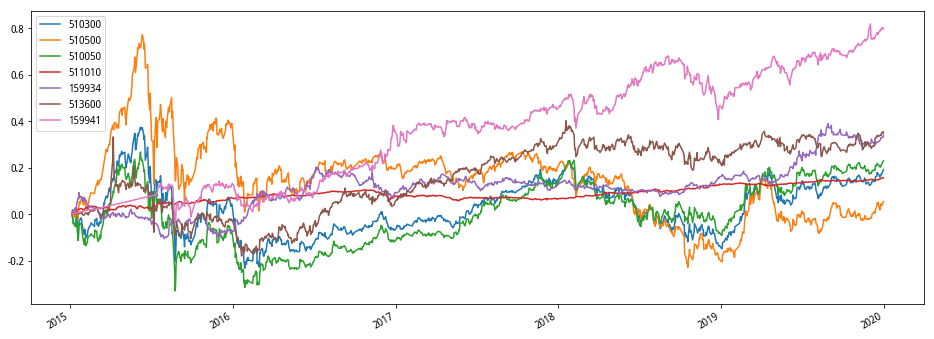

In [2]:
# 各资产累计收益率展示
full_ret_df.cumsum().plot(figsize=(16, 6))

In [3]:
def neg_port_sharpe(w):
    """
    组合夏普率的相反数
    """
    ret_series = (w * ret_df).sum(1)            # 收益率序列
    day_cnt = len(ret_series)                   # 交易日天数
    port_std = ret_series.std() * np.sqrt(250)  # 年化波动率
    # 年化收益率
    port_ret = np.log(np.exp(ret_series.sum()) ** (250 / day_cnt))  
    port_sharpe = port_ret / port_std           # 夏普率
    return -1 * port_sharpe

def port_vol(w):
    """
    组合波动率
    """
    return (w * ret_df).sum(1).std() * np.sqrt(250)

def optimize_weights(vol_thre=0.1):
    """
    优化权重
    """
    bounds = Bounds([0, 0, 0, 0.3, 0, 0, 0], [0.5, 1, 1, 1, 1, 1, 0.1])  # 权重上下界
    lc1 = LinearConstraint([1, 1, 1, 1, 1, 1, 1], 1, 1)    # 权重之和为1
    lc2 = LinearConstraint([1, 1, 1, 1, 0, 1, 1], 0.8, 1)  # 股票和债券类资产的权重和不低于80%
    nc = NonlinearConstraint(port_vol, 0, vol_thre)        # 组合波动率限制
    x0 = [0.05, 0.05, 0.05, 0.2, 0.3, 0.2, 0.15]           # 初始权重
    # 最小化组合夏普率的相反数，即最大化组合夏普率
    res = minimize(neg_port_sharpe, x0, method='trust-constr', bounds=bounds, constraints=[lc1, lc2, nc])
    return res.x

ret_df = full_ret_df
optimal_weights = optimize_weights()
print('最优权重:   {}'.format(optimal_weights.round(4)))
print('组合波动率: %.2f%%' % (port_vol(optimal_weights) * 100))
print('组合夏普率: %.2f' % (-1 * neg_port_sharpe(optimal_weights)))

最优权重:   [0.0 0.0 0.0 0.8121 0.0813 0.0067 0.0999]
组合波动率: 2.94%
组合夏普率: 1.66


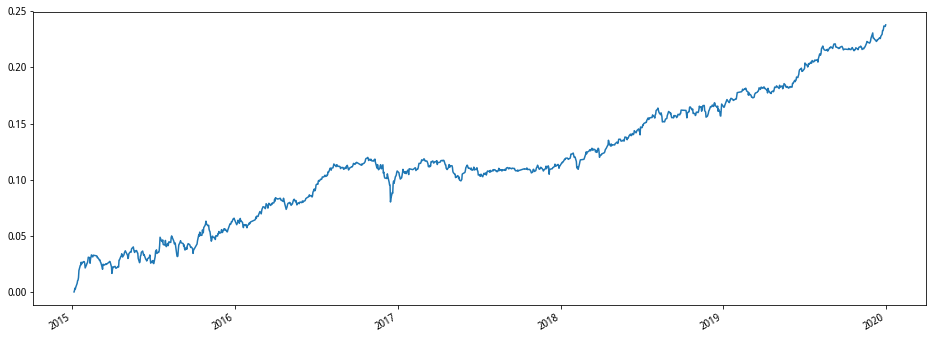

In [4]:
# 组合累计收益率展示
(optimal_weights * full_ret_df).sum(1).cumsum().plot(figsize=(16, 6))

## 任务二

In [5]:
part_ret_df = full_ret_df['2018':]
weight_list, date_list = [], []
for i in trange(len(part_ret_df)):
    cur_date = part_ret_df.index[i]  # 当前日期
    pre_date = None if i == 0 else part_ret_df.index[i - 1]  # 上个交易日
    # 每月初计算最优权重
    if pre_date is None or cur_date.month != pre_date.month:
        # 过去三年的开始与结束时间
        start_date = datetime(cur_date.year - 3, cur_date.month, 1).strftime('%Y-%m-%d')
        end_date = (datetime(cur_date.year, cur_date.month, 1) - timedelta(1)).strftime('%Y-%m-%d')
        ret_df = full_ret_df[start_date:end_date]
        weight_list.append(optimize_weights())
        date_list.append(cur_date)
weight_df = pd.DataFrame(weight_list, date_list, part_ret_df.columns).round(4)
weight_df

100%|██████████| 487/487 [00:08<00:00, 54.89it/s]


,510300,510500,510050,511010,159934,513600,159941
2018-01-02,0.0,0.0,0.0000,0.7989,0.0620,0.0391,0.1000
2018-02-01,0.0,0.0,0.0046,0.7930,0.0497,0.0527,0.1000
2018-03-01,0.0,0.0,0.0000,0.7975,0.0642,0.0383,0.1000
2018-04-02,0.0,0.0,0.0000,0.8091,0.0709,0.0199,0.1000
2018-05-02,0.0,0.0,0.0000,0.8191,0.0721,0.0088,0.1000
2018-06-01,0.0,0.0,0.0000,0.8169,0.0708,0.0123,0.1000
2018-07-02,0.0,0.0,0.0000,0.8301,0.0641,0.0057,0.1000
2018-08-01,0.0,0.0,0.0000,0.7348,0.1289,0.0363,0.1000
2018-09-03,0.0,0.0,0.0000,0.7603,0.0841,0.0557,0.1000
2018-10-08,0.0,0.0,0.0051,0.7452,0.0874,0.0623,0.1000


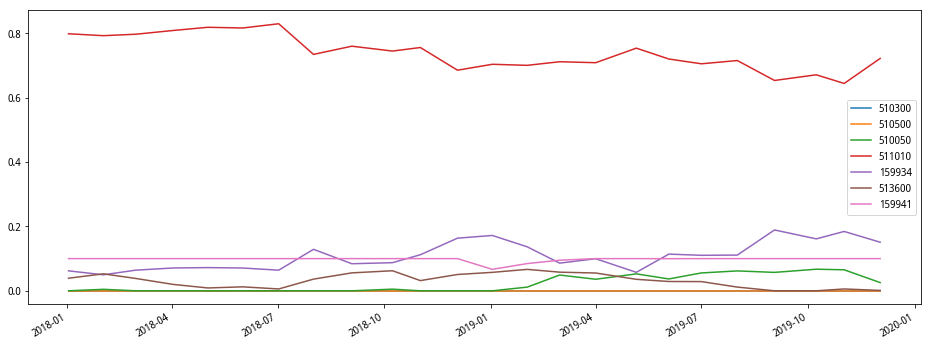

In [6]:
# 最优权重变化展示
weight_df.plot(figsize=(16, 6))

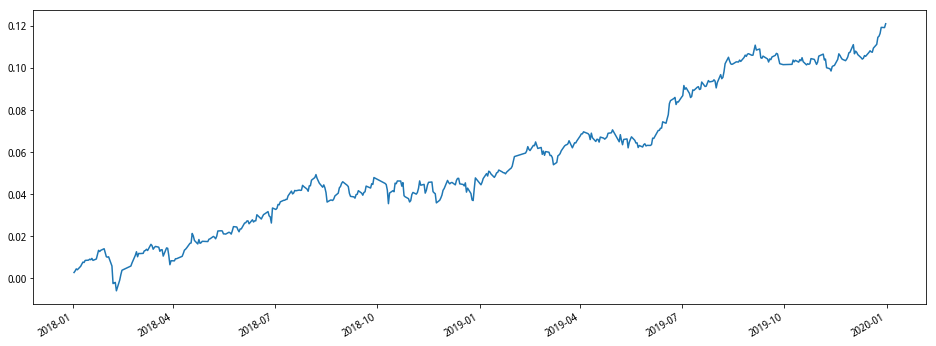

In [7]:
# 组合累计收益率展示
(part_ret_df.iloc[:, :0].join(weight_df).ffill() * part_ret_df).sum(1).cumsum().plot(figsize=(16, 6))

## 任务三

In [8]:
# 读取沪深300指数均线
hs300_df = pd.read_excel('hs300.xlsx', index_col=0)
hs300_df.head()

,close,ma20,ma120
2015-01-05,3641.54,3325.60,2581.69
2015-01-06,3641.06,3351.41,2594.18
2015-01-07,3643.79,3370.96,2606.64
2015-01-08,3559.26,3393.58,2618.20
2015-01-09,3546.72,3409.83,2629.63


In [9]:
part_ret_df = full_ret_df['2018':]
weight_list, date_list = [], []
for i in trange(len(part_ret_df)):
    cur_date = part_ret_df.index[i]  # 当前日期
    pre_date = hs300_df.index[list(hs300_df.index).index(cur_date) - 1]  # 上个交易日
    # 每月初计算最优权重
    if i == 0 or cur_date.month != pre_date.month:
        # 过去三年的开始与结束时间
        start_date = datetime(cur_date.year - 3, cur_date.month, 1).strftime('%Y-%m-%d')
        end_date = (datetime(cur_date.year, cur_date.month, 1) - timedelta(1)).strftime('%Y-%m-%d')
        ret_df = full_ret_df[start_date:end_date]
        # 20日均线高于120日均线
        if hs300_df.loc[pre_date, 'ma20'] > hs300_df.loc[pre_date, 'ma120']:
            vol_thre = 0.15
        # 20日均线低于120日均线
        else:
            vol_thre = 0.05
        weight_list.append(optimize_weights(vol_thre))
        date_list.append(cur_date)
weight_df = pd.DataFrame(weight_list, date_list, part_ret_df.columns).round(4)
weight_df

100%|██████████| 487/487 [00:09<00:00, 49.36it/s]


,510300,510500,510050,511010,159934,513600,159941
2018-01-02,0.0,0.0,0.0000,0.7989,0.0620,0.0391,0.1000
2018-02-01,0.0,0.0,0.0046,0.7930,0.0497,0.0527,0.1000
2018-03-01,0.0,0.0,0.0000,0.7975,0.0642,0.0383,0.1000
2018-04-02,0.0,0.0,0.0000,0.8091,0.0709,0.0199,0.1000
2018-05-02,0.0,0.0,0.0000,0.8191,0.0721,0.0088,0.1000
2018-06-01,0.0,0.0,0.0000,0.8169,0.0708,0.0123,0.1000
2018-07-02,0.0,0.0,0.0000,0.8301,0.0641,0.0057,0.1000
2018-08-01,0.0,0.0,0.0000,0.7348,0.1289,0.0363,0.1000
2018-09-03,0.0,0.0,0.0000,0.7603,0.0841,0.0557,0.1000
2018-10-08,0.0,0.0,0.0051,0.7452,0.0874,0.0623,0.1000


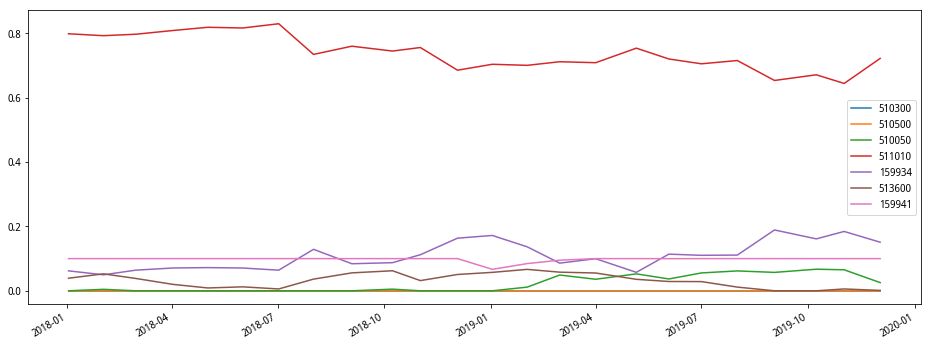

In [10]:
# 最优权重变化展示
weight_df.plot(figsize=(16, 6))

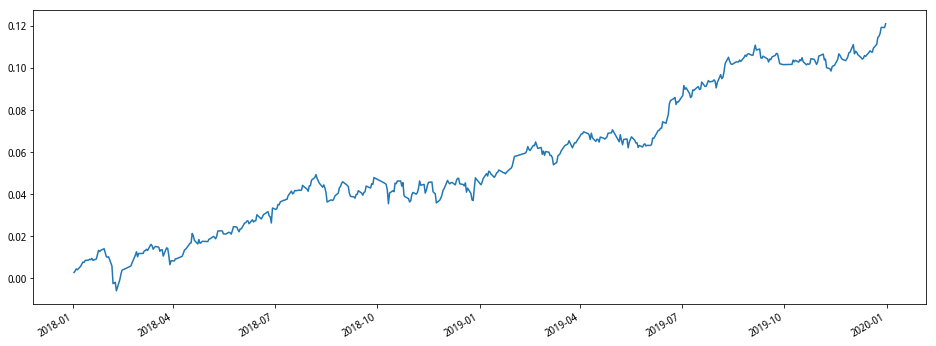

In [11]:
# 组合累计收益率展示
ret_series = (part_ret_df.iloc[:, :0].join(weight_df).ffill() * part_ret_df).sum(1).cumsum()
ret_series.plot(figsize=(16, 6))

## 任务四

In [12]:
value_df = pd.DataFrame()
# 将累计对数收益率序列转为净值序列
value_df['net_value'] = np.exp(ret_series)
# 计算回撤
value_df['drawdown'] = value_df['net_value'] / value_df['net_value'].cummax() - 1
# VaR
VaR = value_df['drawdown'].rolling(250).quantile(0.05)
print('最大回撤：%.2f%%' % (-1 * value_df['drawdown'].min() * 100))
value_df.head()

最大回撤：1.98%


,net_value,drawdown
2018-01-02,1.002811,0.000000
2018-01-03,1.003558,0.000000
2018-01-04,1.004542,0.000000
2018-01-05,1.004123,-0.000417
2018-01-08,1.005806,0.000000


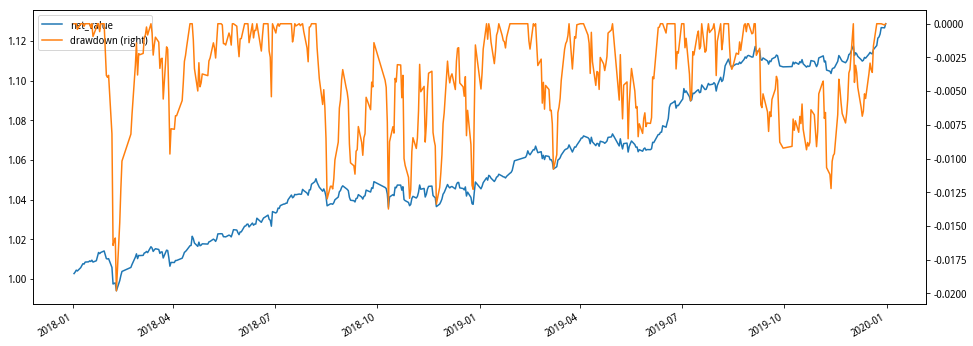

In [13]:
# 净值与回撤展示
value_df.plot(figsize=(16, 6), secondary_y='drawdown')

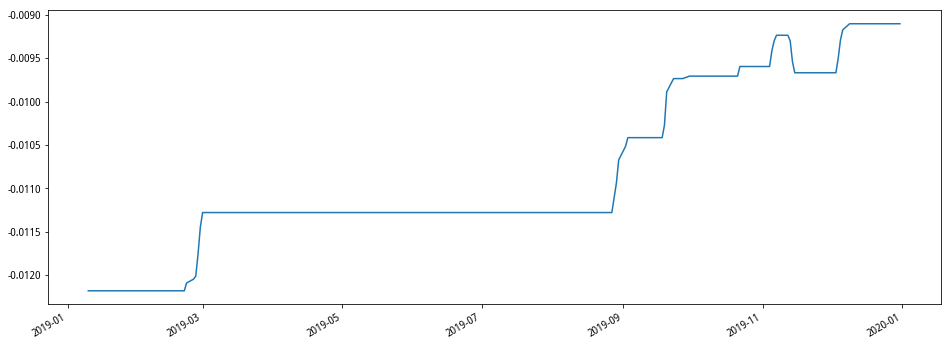

In [14]:
# VaR展示
VaR.plot(figsize=(16, 6))